Original:          SSIM =  1.0        MSE =  0.0


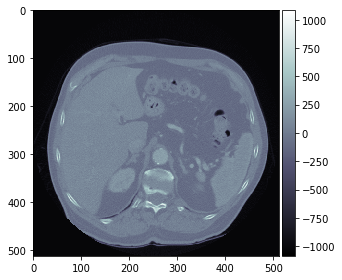

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage import io, filters

%matplotlib inline

def compare_images(title, original, processed):
    mse_noise = mse(original, processed)
    ssim_noise = ssim(original, processed, data_range=processed.max() - processed.min())
    print(title, "        SSIM = ", ssim_noise, "       MSE = ", mse_noise)

# Any results you write to the current directory are saved as output.
lung = pydicom.read_file('c:/temp/000074.dcm')

# convert to HounsField Scale
image = np.stack(lung.pixel_array)

# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
image = image.astype(np.int16)

# Set outside-of-scan pixels to 1
# The intercept is usually -1024, so air is approximately 0
image[image == -2000] = 0

intercept = lung.RescaleIntercept
slope = lung.RescaleSlope
    
if slope != 1:
	image = slope * image.astype(np.float64)
	image = image.astype(np.int16)
        
image += np.int16(intercept)
    
imgs = np.array(image, dtype=np.float64)

io.imshow(imgs, cmap=plt.cm.bone)
compare_images("Original: ", imgs, imgs)


c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in short_scalars


Exposure Rescale Intensity:          SSIM =  0.011597795698408055        MSE =  697385995.418808


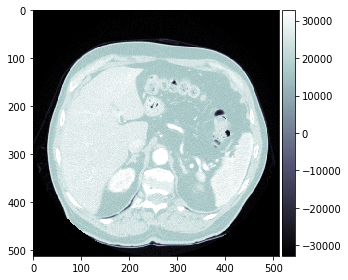

In [26]:
##############################################################################################################
from skimage import exposure

p2, p98 = np.percentile(image, (2, 98))
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
io.imshow(img_rescale, cmap=plt.cm.bone)
compare_images("Exposure Rescale Intensity: ", imgs, img_rescale)



Exposure Histogram Equalization:          SSIM =  -6.850992479212441e-05        MSE =  394345.50598552055


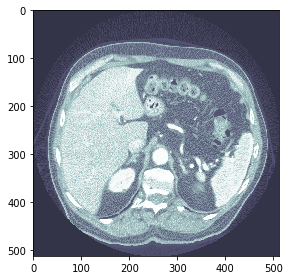

In [27]:
##############################################################################################################

# Histogram Equalization
img_eq = exposure.equalize_hist(image)
io.imshow(img_eq, cmap=plt.cm.bone)
compare_images("Exposure Histogram Equalization: ",imgs, img_eq)



c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from int16 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Exposure Adaptative Equalization:          SSIM =  -1.3127042723447138e-05        MSE =  394259.9781230515


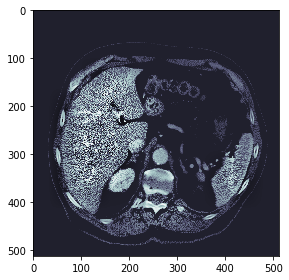

In [33]:
##############################################################################################################

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.15)
io.imshow(img_adapteq, cmap=plt.cm.bone)
compare_images("Exposure Adaptative Equalization: ", image, img_adapteq)

Denoise Chambolle:          SSIM =  1.074388630289893e-05        MSE =  394152.6464329034


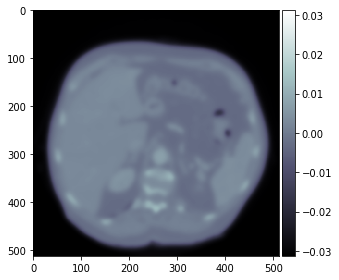

In [34]:
###############################################################################################################

#Denoise Total Variation
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

img_chamboelle = denoise_tv_chambolle(image, weight=0.1, multichannel=False)
io.imshow(img_chamboelle, cmap=plt.cm.bone)
compare_images("Denoise Total Variation: ", image, img_chamboelle)

Denoise Wavelet:          SSIM =  1.0875560512068707e-05        MSE =  394152.02762699674


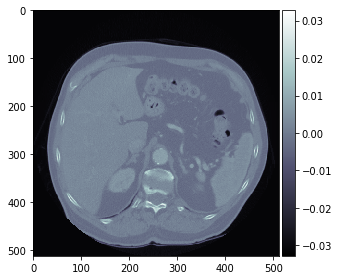

In [35]:
################################################################################################################

#Denoise Wavelet
img_wavelet = denoise_wavelet(image, multichannel=True)
io.imshow(img_wavelet, cmap=plt.cm.bone)
compare_images("Denoise Wavelet: ", image, img_wavelet)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Denoise Wavelet:          SSIM =  1.0007215288423315e-05        MSE =  394133.52156448364


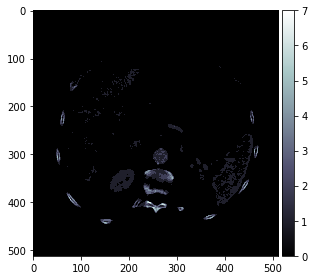

In [39]:
#Filters Median
img_median = filters.median(image)
io.imshow(img_median, cmap=plt.cm.bone)
compare_images("Median Filter: ", image, img_median)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Adaptative Equalization after Wavelet Denoise:          SSIM =  -1.7588003104469154e-05        MSE =  394259.32514121314


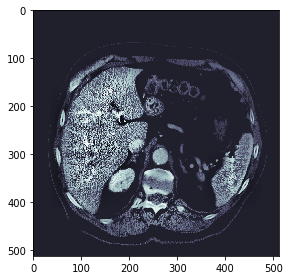

In [40]:
# Adaptive Equalization after Wavelet Denoise
img_adapteqw = exposure.equalize_adapthist(img_wavelet, clip_limit=0.15)
io.imshow(img_adapteqw, cmap=plt.cm.bone)
compare_images("Adaptative Equalization after Wavelet Denoise: ", image, img_adapteqw)

Wavelet Denoise after Adaptative Equalization:          SSIM =  -1.956849398082517e-05        MSE =  394260.8212153934


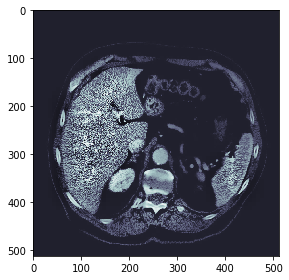

In [42]:
# Wavelet Denoise after Adaptative Equalization
img_waveleteq = denoise_wavelet(img_adapteq, multichannel=False)
io.imshow(img_waveleteq, cmap=plt.cm.bone)
compare_images("Wavelet Denoise after Adaptative Equalization: ", image, img_waveleteq)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Adaptative Equalization after Rescale Intensity and Wavelet Denoise:          SSIM =  -2.3553012940695122e-05        MSE =  394255.81535442977


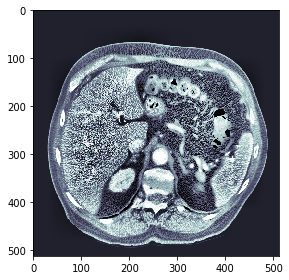

In [44]:
# Adaptive Equalization after Rescale Intensity and Wavelet Denoise
img_rescale_wavelet = denoise_wavelet(img_rescale, multichannel=False)
img_resc_adapteqw = exposure.equalize_adapthist(img_rescale_wavelet, clip_limit=0.15)
io.imshow(img_resc_adapteqw, cmap=plt.cm.bone)
compare_images("Adaptative Equalization after Rescale Intensity and Wavelet Denoise: ", image, img_resc_adapteqw)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from int16 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Wavelet Denoise after Rescale Intensity and Adaptive Equalization:          SSIM =  -2.607344078056255e-05        MSE =  394256.27098850237


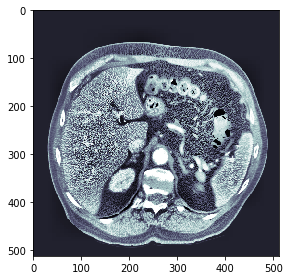

In [45]:
# Wavelet Denoise after Rescale Intensity and Adaptive Equalization
img_rescale_adapt = exposure.equalize_adapthist(img_rescale, clip_limit=0.15)
img_resc_wavelet = denoise_wavelet(img_rescale_adapt, multichannel=False)
io.imshow(img_resc_wavelet, cmap=plt.cm.bone)
compare_images("Wavelet Denoise after Rescale Intensity and Adaptive Equalization: ", image, img_resc_wavelet)

Wavelet Denoise after Rescale Intensity:          SSIM =  0.00035804240932151346        MSE =  393402.3770665297


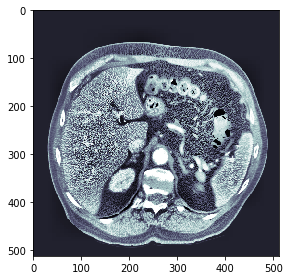

In [46]:
# Wavelet Denoise after Rescale Intensity
img_resc_wavelet2 = denoise_wavelet(img_rescale, multichannel=False)
io.imshow(img_resc_wavelet, cmap=plt.cm.bone)
compare_images("Wavelet Denoise after Rescale Intensity: ", image, img_resc_wavelet2)

Rescale Intensity after Wavelet Denoise:          SSIM =  0.000356443859339415        MSE =  393402.76714771707


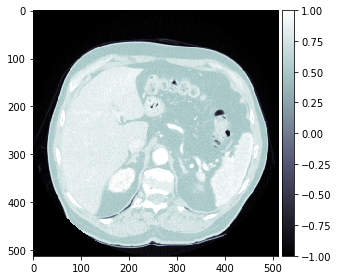

In [47]:
# Rescale Intensity after Wavelet Denoise

p2, p98 = np.percentile(img_wavelet, (2, 98))
img_rescale_w = exposure.rescale_intensity(img_wavelet, in_range=(p2, p98))
io.imshow(img_rescale_w, cmap=plt.cm.bone)
compare_images("Rescale Intensity after Wavelet Denoise: ", image, img_rescale_w)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Mean Bilateral:          SSIM =  0.18118603022449403        MSE =  2858805559.4090157


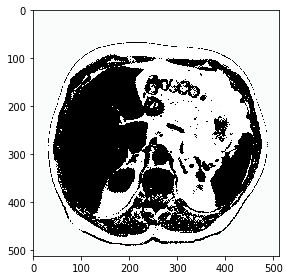

In [55]:
from skimage.filters.rank import mean_bilateral

img_bilateral =  mean_bilateral(image.astype(np.uint16),disk(20), s0=10,s1=15)
io.imshow(img_bilateral, cmap=plt.cm.bone)
compare_images("Mean Bilateral: ", image, img_bilateral)